In [1]:
import numpy as np
from math import cos, sin, pow, exp
import random
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
L = 5.5
t_m = 2
nu = 1

def plotTRAJ(title, x, t, size):
    plt.figure()
    plt.rcParams['figure.figsize'] = size
    plt.style.use('seaborn-whitegrid')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(title)
    ax1.plot(t, x[0])
    ax2.plot(t, x[1])
    ax3.plot(t, x[2])
    plt.show()

# def model(t_start, t_end, initial_val):
#     t_list = list(range(t_start, t_end+1))
#     x = np.zeros((3, len(t_list)))
#     x[0][0] = initial_val[0]
#     x[1][0] = initial_val[1]
#     x[2][0] = initial_val[2]
#     for t in range(1, t_end-t_start+1):
#         x[0][t] = 0.3 * x[0][t-1] + 0.3 * cos(0.1 * pow((t-1), 2) + 2.5)
#         x[1][t] = x[1][t-1] + 0.6 * cos(1.4 * x[0][t-1] + x[1][t-1]) 
#         x[2][t] = 0.02 * pow(x[2][t-1], 2) + 0.1 * sin(x[0][t-1] + x[2][t-1]) + x[0][t-1]
#     return x, t_list
def model(t_start, t_end, initial_val):
    t_list = list(range(t_start, t_end+1))
    x = np.zeros((3, len(t_list)))
    x[0][0] = initial_val[0]
    x[1][0] = initial_val[1]
    x[2][0] = initial_val[2]
    i = 0
    for t in range(t_start+1, t_end+1):
        i += 1
        x[0][i] = (1 - nu*t_m/L) * x[0][i-1] + 0.5 * cos(0.1 * pow((t-1), 3) + 2)
        x[1][i] = x[1][i-1] + (nu*t_m/L) * x[0][i-1] 
        x[2][i] = x[2][i-1] + (nu*t_m) * sin(0.005*x[1][i-1] + (nu*t_m/(2*L))*x[0][i-1]) 
    return x, t_list

# def update_instance(cur_instance, x_new, t_new, gradient, flag):
#     ### flag = 'g' means new_val = original_val += gradient
#     ### flag = 'v' means new_val = gradient
#     x_before = deepcopy(cur_instance[:, :t_new])
#     x_current = deepcopy(cur_instance[:, t_new])
# #     print('before this update: x_current: ', x_current)
#     if flag == 'g':
#         x_current[x_new] += gradient
#     elif flag == 'v':
#         x_current[x_new] = gradient
# #     print('after this update: x_current: ', x_current)
#     t_end = cur_instance.shape[1] - 1
# #     print('t_new, t_end: ', t_new,  t_end)
#     x_after, _ = model(t_new, t_end, x_current)
# #     print('x_after: ',  x_after.shape, x_after)
#     X = np.concatenate((x_before, x_after), axis=1)
#     return X

def update_instance(cur_instance, x_new, t_new, gradient, flag):
    ### flag = 'g' means new_val = original_val += gradient
    ### flag = 'v' means new_val = gradient
    x = deepcopy(cur_instance)
    if flag == 'g':
        x[x_new, t_new] += gradient
    elif flag == 'v':
        x[x_new, t_new] = gradient
    for t in range(x.shape[1]):
        if t > t_new:
            if x_new == 0: ### update x1
#                 x[0][t] = 0.3 * x[0][t-1] + 0.3 * cos(0.1 * pow((t-1), 2) + 2.5)
#                 x[1][t] = x[1][t-1] + 0.6 * cos(1.4 * x[0][t-1] + x[1][t-1]) 
#                 x[2][t] = 0.02 * pow(x[2][t-1], 2) + 0.1 * sin(x[0][t-1] + x[2][t-1]) + x[0][t-1]
                x[0][t] = (1 - nu*t_m/L) * x[0][t-1] + 0.5 * cos(0.1 * pow((t-1), 3) + 2)
                x[1][t] = x[1][t-1] + (nu*t_m/L) * x[0][t-1] 
                x[2][t] = x[2][t-1] + (nu*t_m) * sin(0.005*x[1][t-1] + (nu*t_m/(2*L))*x[0][t-1])
            elif x_new == 1: ### update x2
                x[1][t] = x[1][t-1] + (nu*t_m/L) * x[0][t-1] 
                x[2][t] = x[2][t-1] + (nu*t_m) * sin(0.005*x[1][t-1] + (nu*t_m/(2*L))*x[0][t-1])
            elif x_new == 2: ### update x3
                x[2][t] = x[2][t-1] + (nu*t_m) * sin(0.005*x[1][t-1] + (nu*t_m/(2*L))*x[0][t-1])
    return x


def fault_instance(t_start, t_fault, t_end, initial_val, fault_flag, fault_val):
    x_before, t_before = model(t_start, t_fault, initial_val)
    x_current = x_before[:, -1]
    if fault_flag == 'x1':
        idx = 0
    elif fault_flag == 'x2':
        idx = 1
    elif fault_flag == 'x3':
        idx = 2    
    x_current[idx] = fault_val
    x_after, t_after = model(t_fault, t_end, x_current)
    X = np.concatenate((x_before[:, :t_fault], x_after), axis=1)
    T = t_before[:t_fault] + t_after
    return X, T


def fault_proba(instance_set, formula):
    t_fault = formula['t_c']
    t_effect = formula['t_e']
    time_to_check = list(range(t_fault, instance_set.shape[2]))
#     print('time_to_check: ', time_to_check)
    effect = formula['effect']
    effect_sig = formula['effect_sig']
    effect_threshold = formula['effect_threshold']
#     print('fault_p: instance_set: ', instance_set.shape, t_fault)
    if effect == 'x1':
        temp_matrix = instance_set[:, 0, t_effect]
    elif effect == 'x2':
        temp_matrix = instance_set[:, 1, t_effect]
    elif effect == 'x3':
        temp_matrix = instance_set[:, 2, t_effect]
    if effect_sig  == '>=':
        instance_sat_list = []
        t_list = []
#         print('temp_matrix_value: ', temp_matrix)
#         print('temp_matrix: ', temp_matrix.shape[0])
        for idx in range(temp_matrix.shape[0]):
    
#             print('idx: ', idx)
#             for t in range(temp_matrix.shape[1]):
            val = temp_matrix[idx]
            if val >= effect_threshold:
#                     print('save idx: ', idx)
                save_instance = instance_set[idx]
#                     print('save_instance: ', save_instance[0, 4])
                instance_sat_list.append(save_instance)
#                 t_list.append(time_to_check[t])
#     return np.array(instance_sat_list), t_list, np.mean(t_list), len(t_list) / (instance_set.shape[0])
    return np.array(instance_sat_list), np.array(instance_sat_list).shape[0] / (instance_set.shape[0])

def check(instance, t_ot, formula):
    effect = formula['effect']
    effect_sig = formula['effect_sig']
    effect_threshold = formula['effect_threshold']
    if effect == 'x3':
        idx = 2
    if effect_sig  == '>=':
        if instance[idx, t_ot] >= effect_threshold:
            return 0
        else:
            return 1
    return 0


def intervene_instance(feature_list, step, CF_candi, flag):
    ### feature_list can include one or multiple features with the format: [(x_i, t)]
    ### feature_list = [(0, 4), (1, 3)] means intervene on features x_1(4), x_2(3)
    ### step = [-0.1, -0.01] means we want to give x_1(4) step of -0.1, give x_2(3) step of -0.01, respectively
    cur_CF_candi = deepcopy(CF_candi)
#     print('cur_CF_candi: ', cur_CF_candi)
    old_list = zip(feature_list, step, flag)
    sorted_feature_list = sorted(old_list, key=lambda pair: (pair[0][1], pair[0][0]))
    for ((x, t), g, f) in sorted_feature_list:
#         print('(x, t), g, f: ', x, t, g, f)
#         print('before update: ', cur_CF_candi)
        cur_CF_candi = update_instance(cur_CF_candi, x, t, g, f)
#         print('after update: ', cur_CF_candi)
    return cur_CF_candi

def loss_for_CF(feature_list, instance, t_abn_effect, CF):
    lmbda1 = 1000
    lmbda2 = 0.5
    ### feature_list can include one or multiple features with the format: [(x_i, t)]
    ### feature_list = [(0, 4), (1, 3)] means intervene on features x_1(4), x_2(3)
    orginal_value = instance[2, t_abn_effect]
#     term_1 = exp(CF[2, t_abn_effect] - orginal_value)
    term_1 = CF[2, t_abn_effect] - orginal_value
    temp_1 = []
    for (x, t) in feature_list:
        temp_1.append(abs(instance[x, t] - CF[x, t]))
    term_2 = np.mean(temp_1)
    loss = lmbda1 * term_1 - lmbda2 * term_2
    return loss

def get_CF(feature_list, instance, t_abn_effect, feature_range, lr, step, wordy=False, keep_val=None):
    sgd_count = 15
    ### step = [0.1, 0.3] means step is 0.1 for the 1st feature, 0.3 for the 2nd feature
    ### feature_range = [(-1, 1), (-0.5, 0.5)] means ranges of features x_1(4), x_2(3), respectively
    ### set initial values of each features for each CFs based on range_eachCF
    intervene_feature_list = deepcopy(feature_list)
    if keep_val:
        intervene_feature_list.append((keep_val['x'], keep_val['t']))
    CF = deepcopy(instance)
#     reset_diff = []
#     for j in range(len(feature_list)):
#         random.seed(j)
#         x, t = feature_list[j]
#         left, right = feature_range[j]
#         reset_init_value = random.uniform(left, right)     
#         reset_diff.append(reset_init_value - instance[x, t])
#     CF = intervene_instance(feature_list, reset_diff, CF)
    if wordy:
        print('initial CF: ', CF)
    reset_diff = []
    flag_list = []
    for j in range(len(feature_list)):
#         random.seed(j)
        x, t = deepcopy(feature_list[j])
#         left, right = -0.01, 0.01
        if wordy:
            print('feature range is reset to: ', feature_range[j])
        left, right = deepcopy(feature_range[j])
        new_val = random.uniform(left, right)
        if wordy:
            print('new val at: ', x, t, 'is: ', new_val)
            print('current value at: ', x, t, 'is: ', CF[x, t])
        reset_diff.append(new_val)
        flag_list.append('v')
    if wordy:
        print('intervene_feature_list: ', intervene_feature_list)
        print('reset_diff: ', reset_diff)
        print('before intervene: ', CF)
    if keep_val:
        reset_diff.append(keep_val['val'])
        flag_list.append('v')
    CF = intervene_instance(intervene_feature_list, reset_diff, CF, flag_list)
    if wordy:
        print('after intervene: ', CF)
    
    for sgd_c in range(sgd_count):
        ### 对于每个feature分别加扰动
        diff_list = [0 for _ in range(len(feature_list))]
        val_list = [0 for _ in range(len(feature_list))]
        flag_list = ['v' for _ in range(len(feature_list))]
        sgd_val_list = []
        for j in range(len(feature_list)):
            cur_feature = deepcopy(feature_list[j])
            x, t = cur_feature
            sgd_val_list.append(CF[x, t])
        sgd_flag_list = ['v' for _ in range(len(feature_list))]
        if keep_val:
            val_list.append(keep_val['val'])
            flag_list.append('v')
            sgd_val_list.append(keep_val['val'])
            sgd_flag_list.append('v')
        for j in range(len(feature_list)):
            cur_feature = deepcopy(feature_list[j])
            cur_step = step[j]
            x, t = cur_feature
            left, right = deepcopy(feature_range[j])
            ## range
            if CF[x, t] + cur_step > right or CF[x, t] - cur_step < left:
#                 print('CF STEP')
                diff = 0
                val_list[j] = CF[x, t]
            else:
                cur_sgd_val_plus = deepcopy(sgd_val_list)
                cur_sgd_val_minus = deepcopy(sgd_val_list)
                cur_sgd_val_plus[j] += cur_step
                cur_sgd_val_minus[j] -= cur_step
                CF_plus = intervene_instance(intervene_feature_list, cur_sgd_val_plus, CF, sgd_flag_list)
                loss_plus = loss_for_CF([cur_feature], instance, t_abn_effect, CF_plus)
                CF_minus = intervene_instance(intervene_feature_list, cur_sgd_val_minus, CF, sgd_flag_list)
                loss_minus = loss_for_CF([cur_feature], instance, t_abn_effect, CF_minus)
                diff = - lr * (loss_plus - loss_minus) / (2 * cur_step)
                new_val = CF[x, t] + diff
                if new_val > right or new_val < left:
#                     print('CF gradient')
                    diff = 0
                    val_list[j] = CF[x, t]
                else:
                    diff_list[j] = diff
                    val_list[j] = CF[x, t] + diff
        if all(np.array(diff_list) == 0):
#             print(f'{sgd_c}: all gradients are zero')
            break
        else:
            CF = intervene_instance(intervene_feature_list, val_list, CF, flag_list)
    return CF
    

    
def get_feature_range_necessity(formula, ratio):
    th = formula['cause_threshold']
    if formula['cause_sig'] == '>=' or formula['cause_sig'] == '>':
        f_range = (th-ratio*abs(th), th)
    elif formula['cause_sig'] == '<=' or formula['cause_sig'] == '<':
        f_range = (th, th+ratio*abs(th))
    return f_range       

def get_feature_range(instance, feature_list, ratio, intervene_feature, formula):
    intervene_f_x, intervene_f_t = intervene_feature
    feature_range = []
    for (x, t) in feature_list:
        if x == intervene_f_x and t == intervene_f_t:
            f_range = get_feature_range_necessity(formula, ratio)
        else:
            instance_val = instance[x, t]
            f_range = (instance_val-ratio*abs(instance_val), instance_val+ratio*abs(instance_val))
    #         f_range = (-0.7, 3)
    #         print(f'({x}, {t})\tinstance: {instance_val}\tfeature_range: {f_range}')
        feature_range.append(f_range)
    return feature_range 
            

def cal_similarity(instance_set, fault, effect):
    if effect == 'x1':
        idx = 0
    elif effect == 'x2':
        idx = 1
    elif effect == 'x3':
        idx = 2
    sim_list = []
    for i in range(instance_set.shape[0]):
        instance = instance_set[i]
        sim_temp = np.mean(abs(instance[idx, :] - fault[idx, :]))
#         sim_temp = np.mean(pow(instance[idx, :] - fault[idx, :],2))
        sim_list.append(sim_temp)
#     return np.mean(sim_list)
    return np.min(sim_list)


def instance_generation(formula):
    instance_set = []
    for fault_val in np.arange(formula['cause_threshold'], formula['cause_threshold']*(1+0.25), 0.01):
        x_abn_effect, t_abn_effect = fault_instance(0, formula['t_c'], 60, [0, 4, 0], formula['cause'], fault_val)
        instance_set.append(x_abn_effect)

    instance_set = np.array(instance_set)
    instance_sat_list,instance_sat_prob = fault_proba(instance_set, formula)
    return instance_set, instance_sat_list,instance_sat_prob

def Necessity(numCF, instance_sat_prob, instance_sat_list, formula, ratioCF, step_NN):
    nCF = numCF
    N = instance_sat_list.shape[0]
    
    if formula['cause'] == 'x1':
        x = 0
    elif formula['cause'] == 'x2':
        x = 1
    elif formula['cause'] == 'x3':
        x = 2
    else:
        print('wrong')
    t = formula['t_c']
    feature_list = [(x, t)]
    ratio = ratioCF
    lr = 0.0000001
    step  = [step_NN]
    count = 0
    Prob = instance_sat_prob
    if Prob < 0.3:
        necessity = 0
    else:
        for i in range(N):
            instance = deepcopy(instance_sat_list[i])
        #     print('instance ', instance)
            t_abn_effect = formula['t_e']
    #         print('t_abn_effect ', t_abn_effect)
            feature_range = get_feature_range_necessity(formula, ratio)
        #     print(feature_list, feature_range)
            for _ in range(nCF):
                cur_cf = get_CF(feature_list, instance, t_abn_effect, [feature_range], lr, step, False)
        #         print('cur_cf: ', cur_cf[2,39])
                if cur_cf[2, t_abn_effect] < formula['effect_threshold']:
                    count += 1
        necessity = count / (nCF * N)
    return necessity

def Sufficiency(numCF, instance_sat_prob, instance_sat_list, formula, ratioCF,step_SS):
    nCF = numCF
    N = instance_sat_list.shape[0]
    if formula['cause'] == 'x1':
        x = 0
    elif formula['cause'] == 'x2':
        x = 1
    elif formula['cause'] == 'x3':
        x = 2
    else:
        print('wrong')
    t = formula['t_c']
    intervene_feature = (x, t)
    ratio = ratioCF
    lr = 0.00001
    Prob = instance_sat_prob
    if Prob < 0.3:
        sufficiency = 0
    else:
        s1 = 0
        feature_list = [intervene_feature, (1, t), (2,t)]
        step  = [step_SS for _ in range(len(feature_list))]
        for i in range(N):
            instance = deepcopy(instance_sat_list[i])
        #     print('instance ', instance)
            t_abn_effect = formula['t_e']
            feature_range = get_feature_range(instance, feature_list, ratio, intervene_feature, formula)
            for _ in range(nCF):
                cur_cf = get_CF(feature_list, instance, t_abn_effect, feature_range, lr, step, False)
        #         print('cur_cf1 ', cur_cf[2,36])
                if cur_cf[2, t_abn_effect] < formula['effect_threshold']:
                    s1 += 1
        s2 = 0
        # print('before: ', feature_list)
        feature_list.remove(intervene_feature)
        # print('after: ', feature_list)

        for i in range(N):
            instance = deepcopy(instance_sat_list[i])
            keep_value = dict()
            keep_value['x'] = x
            keep_value['t'] = t
            keep_value['val'] = instance[x, t]
        #     print('instance: ', instance)
            t_abn_effect = formula['t_e']
            feature_range = get_feature_range(instance, feature_list, ratio, intervene_feature, formula)
            for _ in range(nCF):
        #         print('feature_list ', feature_list, 'feature_range: ', feature_range)
                cur_cf = get_CF(feature_list, instance, t_abn_effect, feature_range, lr, step, False, keep_value)
        #         print('cur_cf2 ', cur_cf[2,36])
                if cur_cf[2, t_abn_effect] < formula['effect_threshold']:
                    s2 += 1

        sufficiency = s1 / (nCF * N) - s2 / (nCF * N)
    return sufficiency

def Formula(t_c, cause, cause_sig, cause_threshold, t_e, effect, effect_sig, effect_threshold):
    formula = {}
    formula['t_c'] = t_c
    formula['cause'] = cause
    formula['cause_sig'] = cause_sig
    formula['cause_threshold'] = cause_threshold
    formula['t_e'] = t_e
    formula['effect'] = effect
    formula['effect_sig'] = effect_sig
    formula['effect_threshold'] = effect_threshold
    return formula

### 1. Input a formula with format: x_i(t) ~ a -> x_j(t+d) ~ b
##### Please specify the following variables:

In [8]:
## if the formula is x_1(4) >= 0.2 -> x_3(4 + d) >= 0.4
### 
# formula = {}
# formula['t_c'] = 35
# formula['cause'] = 'x1'
# formula['cause_sig'] = '>='
# formula['cause_threshold'] = 1.4
# formula['t_e'] = 38
# formula['effect'] = 'x3'
# formula['effect_sig'] = '>='
# formula['effect_threshold'] = 0.4
# formula
formula = Formula(35, 'x1', '>=', 1.3, 38, 'x3', '>=', 0.4)
print ('formula', formula)

formula {'t_c': 35, 'cause': 'x1', 'cause_sig': '>=', 'cause_threshold': 1.3, 't_e': 38, 'effect': 'x3', 'effect_sig': '>=', 'effect_threshold': 0.4}


### 2. Actual Fault 

In [42]:
x_correct, t_correct = model(0, 60, [0, 4, 0])
x_real_fault, t_real_fault = fault_instance(0, 32, 60, [0, 4, 0], 'x1', 0.7)

<Figure size 1080x216 with 0 Axes>

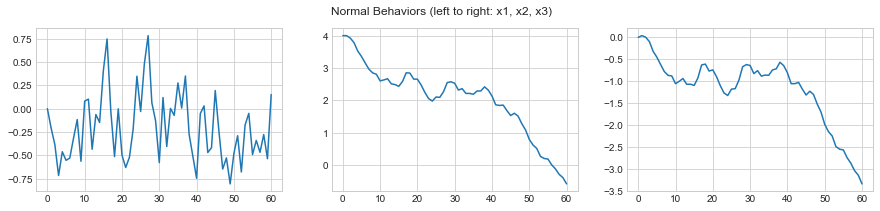

In [43]:
plotTRAJ('Normal Behaviors (left to right: x1, x2, x3)', x_correct, t_correct, (15,3))

<Figure size 1080x216 with 0 Axes>

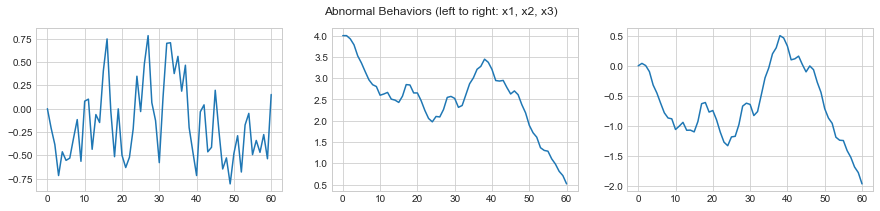

In [44]:
plotTRAJ('Abnormal Behaviors (left to right: x1, x2, x3)', x_real_fault, t_real_fault, (15,3))

In [45]:
import csv
x1_1 = ['x_correct'] + x_correct[0].tolist()
x1_2 = ['x_correct'] + x_correct[1].tolist()
x1_3 = ['x_correct'] + x_correct[2].tolist()
t1 = ['t_correct'] + t_correct
x2_1 = ['x_real_fault'] + x_real_fault[0].tolist()
x2_2 = ['x_real_fault'] + x_real_fault[1].tolist()
x2_3 = ['x_real_fault'] + x_real_fault[2].tolist()
t2 = ['t_real_fault'] + t_real_fault

with open('temp.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(x1_1)
    writer.writerow(x1_2)
    writer.writerow(x1_3)
    writer.writerow(t1)
    writer.writerow(x2_1)
    writer.writerow(x2_2)
    writer.writerow(x2_3)
    writer.writerow(t2)  

In [47]:
import pandas as pd
temp = pd.read_csv('temp.csv')
temp = temp.T
temp
temp.to_csv('temp_1.csv')

### 3. Instance generation 

In [ ]:
instance_set,instance_sat_list,instance_sat_prob = instance_generation(formula)
print('formula',formula)
print('instance_sat_prob',instance_sat_prob)

In [ ]:
simlarity = cal_similarity(instance_set, x_real_fault, 'x3')
print('simlarity',simlarity)

### 4. Calculate Necessity & Sufficiency

##### 4.1 Necessity

In [ ]:
necessity = Necessity(2, instance_sat_prob, instance_sat_list, formula, 0.4, step_NN)
# necessity = Necessity(numCF, instance_sat_list, formula, ratioCF)
print('necessity: ', necessity)

##### 4.2 Sufficiency

In [ ]:
sufficiency = Sufficiency(2, instance_sat_prob, instance_sat_list, formula, 0.4,step_SS)
print('sufficiency: ', sufficiency)

# print(instance_sat_list[0, 0, 5], instance_sat_list[1, 0, 5], instance_sat_list[2, 0, 5])

###  test

In [ ]:
x_real_fault, t_real_fault = fault_instance(0, 34, 60, [0, 4, 0], 'x1', 1.5)

M = 20
t_cause = 31
cause_val = 0.9
t_effect = 38
effect_val = 0.4

w1 = 0.1
w2 = 7.2
w3 = 1
w4 = 1
step_L = 0.001
lr_L = 0.001
numCF = 5

SN_Ratio = 0.1
step_NN = step_SS = 0.00025

Existence_L  = []
Error_L = []
Necessity_L = []
Sufficiency_L = []
Score_L = []
for _ in range(M):
    
    formula = Formula(t_cause, 'x1', '>=', cause_val, t_effect, 'x3', '>=', effect_val)
    print('t_cause',t_cause)
    print('cause_val',cause_val)
    
    instance_set,instance_sat_list,instance_sat_prob = instance_generation(formula)
#     print('instance_sat_prob',instance_sat_prob)
    
    simlarity = cal_similarity(instance_set, x_real_fault, 'x3')
    print('simlarity',simlarity)
    
    necessity = Necessity(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_NN)
    print('necessity: ', necessity)
    
    sufficiency = Sufficiency(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_SS)
    print('sufficiency: ', sufficiency)
    Score_Orig = -w1*instance_sat_prob + w2*simlarity - w3*necessity - w4*sufficiency
    
    Existence_L.append(instance_sat_prob)
    Error_L.append(simlarity)
    Necessity_L.append(necessity)
    Sufficiency_L.append(sufficiency)
    Score_L.append(Score_Orig)
    
    t_g_P = t_cause + 1
    
    formula = Formula(t_g_P, 'x1', '>=', cause_val, t_effect, 'x3', '>=', effect_val)
    instance_set,instance_sat_list,instance_sat_prob = instance_generation(formula)
#     print('instance_sat_prob_tP',instance_sat_prob)
    
    simlarity = cal_similarity(instance_set, x_real_fault, 'x3')
#     print('simlarity_tP',simlarity)
    
    necessity = Necessity(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_NN)
#     print('necessity_tP', necessity)
    
    sufficiency = Sufficiency(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_SS)
#     print('sufficiency_tP', sufficiency)
    Score_t_P = -w1*instance_sat_prob + w2*simlarity - w3*necessity - w4*sufficiency
    
    
    t_g_M = t_cause - 1
    
    formula = Formula(t_g_M, 'x1', '>=', cause_val, t_effect, 'x3', '>=', effect_val)
    instance_set,instance_sat_list,instance_sat_prob = instance_generation(formula)
#     print('instance_sat_prob_tM',instance_sat_prob)
    
    simlarity = cal_similarity(instance_set, x_real_fault, 'x3')
#     print('simlarity_tM',simlarity)
    
    necessity = Necessity(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_NN)
#     print('necessity_tM', necessity)
    
    sufficiency = Sufficiency(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_SS)
#     print('sufficiency_tM', sufficiency)
    Score_t_M = -w1*instance_sat_prob + w2*simlarity - w3*necessity - w4*sufficiency
    
    
    x_g_P = cause_val + step_L
    
    formula = Formula(t_cause, 'x1', '>=', x_g_P, t_effect, 'x3', '>=', effect_val)
    instance_set,instance_sat_list,instance_sat_prob = instance_generation(formula)
#     print('instance_sat_prob_xP',instance_sat_prob)
    
    simlarity = cal_similarity(instance_set, x_real_fault, 'x3')
#     print('simlarity_xP',simlarity)
    
    necessity = Necessity(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_NN)
#     print('necessity_xP', necessity)
    
    sufficiency = Sufficiency(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_SS)
#     print('sufficiency_xP', sufficiency)
    Score_x_P = -w1*instance_sat_prob + w2*simlarity - w3*necessity - w4*sufficiency
    
    
    x_g_M = cause_val - step_L
    
    formula = Formula(t_cause, 'x1', '>=', x_g_M, t_effect, 'x3', '>=', effect_val)
    instance_set,instance_sat_list,instance_sat_prob = instance_generation(formula)
#     print('instance_sat_prob_xM',instance_sat_prob)
    
    simlarity = cal_similarity(instance_set, x_real_fault, 'x3')
#     print('simlarity_xM',simlarity)
    
    necessity = Necessity(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_NN)
#     print('necessity_xM', necessity)
    
    sufficiency = Sufficiency(numCF, instance_sat_prob, instance_sat_list, formula, SN_Ratio, step_SS)
#     print('sufficiency_xM', sufficiency)
    Score_x_M = -w1*instance_sat_prob + w2*simlarity - w3*necessity - w4*sufficiency
    
    
    grad_L = (Score_x_P-Score_x_M)/(2*step_L)
    print('grad',grad_L)
    cause_val = cause_val - lr_L*grad_L
    print('grad*L',lr_L*grad_L)
    if np.argmin([Score_t_P,Score_t_M,Score_Orig]) == 0:
        t_cause = t_g_P
    elif np.argmin([Score_t_P,Score_t_M,Score_Orig]) == 1:
        t_cause = t_g_M
    elif np.argmin([Score_t_P,Score_t_M,Score_Orig]) == 2:
        t_cause = t_cause

In [ ]:
plt.figure()
plt.rcParams['figure.figsize'] = (15,15)
plt.style.use('seaborn-whitegrid')

plt.subplot(3, 2, 1)
plt.plot(list(range(M)),Existence_L, 'b.-.')
plt.title("Existence")

plt.subplot(3, 2, 2)
plt.plot(list(range(M)),Error_L, 'b.-.')
plt.title("Error")

plt.subplot(3, 2, 3)
plt.plot(list(range(M)),Necessity_L, 'b.-.')
plt.title("Necessity")

plt.subplot(3, 2, 4)
plt.plot(list(range(M)),Sufficiency_L, 'b.-.')
plt.title("Sufficiency")

plt.subplot(3, 2, 5)
plt.plot(list(range(M)),Score_L, 'b.-.')
plt.title("Loss")